In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import numpy as np
import pandas as pd

def load_ihdp_data(ihdp_path: Path) -> tuple[pd.DataFrame, list[str], str]:
    ihdp_cols = [s[:-1] for s in np.loadtxt(ihdp_path / "columns.txt", dtype=str)][:-2]
    ihdp_cols.extend([f"x{i}" for i in range(2, 26)])

    csvs = []
    for csv_path in (ihdp_path / "csv").glob("*.csv"):
        csvs.append(pd.read_csv(csv_path, header=None))
        break # TODO choose a table, for now using the first table
    data = pd.concat(csvs)
    data.columns = ihdp_cols

    y_col_name = "delta_y"
    data[y_col_name] = (data["y_cfactual"] - data["y_factual"]) * (-1) ** data["treatment"]
    exclude_cols = ["treatment", "y_cfactual", "y_factual", "mu0", "mu1"]
    return data, exclude_cols, y_col_name

ihdp_data, ihdp_exclude_cols, ihdp_y_colname = load_ihdp_data(Path("/Users/vzuev/Documents/git/gh_zuevval/tabrel/CEVAE/datasets/IHDP"))
ihdp_data.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x17,x18,x19,x20,x21,x22,x23,x24,x25,delta_y
0,1,11.267344,6.314020,6.151308,11.160778,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,0,0,0,0,0,0,4.953324
1,0,3.966599,9.136500,2.633272,10.312341,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,0,0,0,0,0,0,5.169901
2,0,3.403815,10.527021,4.532332,10.855350,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,0,1,1,0,0,0,0,0,0,7.123206
3,0,3.471264,10.890649,4.310770,10.805230,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,0,1,1,0,0,0,0,0,0,7.419385
4,0,4.531366,11.504950,5.621538,11.070719,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,0,0,0,0,0,0,6.973584


In [2]:
from typing import Final

x_all = ihdp_data.drop(columns=ihdp_exclude_cols + [ihdp_y_colname])

ihdp_last_numeric_index: Final[int] = 6
x_numeric = x_all.iloc[:, :ihdp_last_numeric_index]
x_cat = x_all.iloc[:, ihdp_last_numeric_index:]
x_numeric

,x1,x2,x3,x4,x5,x6
0,-0.528603,-0.343455,1.128554,0.161703,-0.316603,1.295216
1,-1.736945,-1.802002,0.383828,2.244320,-0.629189,1.295216
2,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,-0.526556
3,0.390083,0.596582,-1.850350,-0.879606,-0.004017,-0.857787
4,-1.045229,-0.602710,0.011465,0.161703,0.683672,-0.360940
...,...,...,...,...,...,...
742,-0.007654,-0.202946,-0.360898,0.161703,-0.316603,1.792063
743,0.727295,-0.202946,-0.733261,-0.879606,0.808706,1.129600
744,1.181234,0.196818,-1.477987,0.161703,0.746189,0.467138
745,-0.288664,-0.202946,-1.477987,-0.879606,1.621430,0.467138


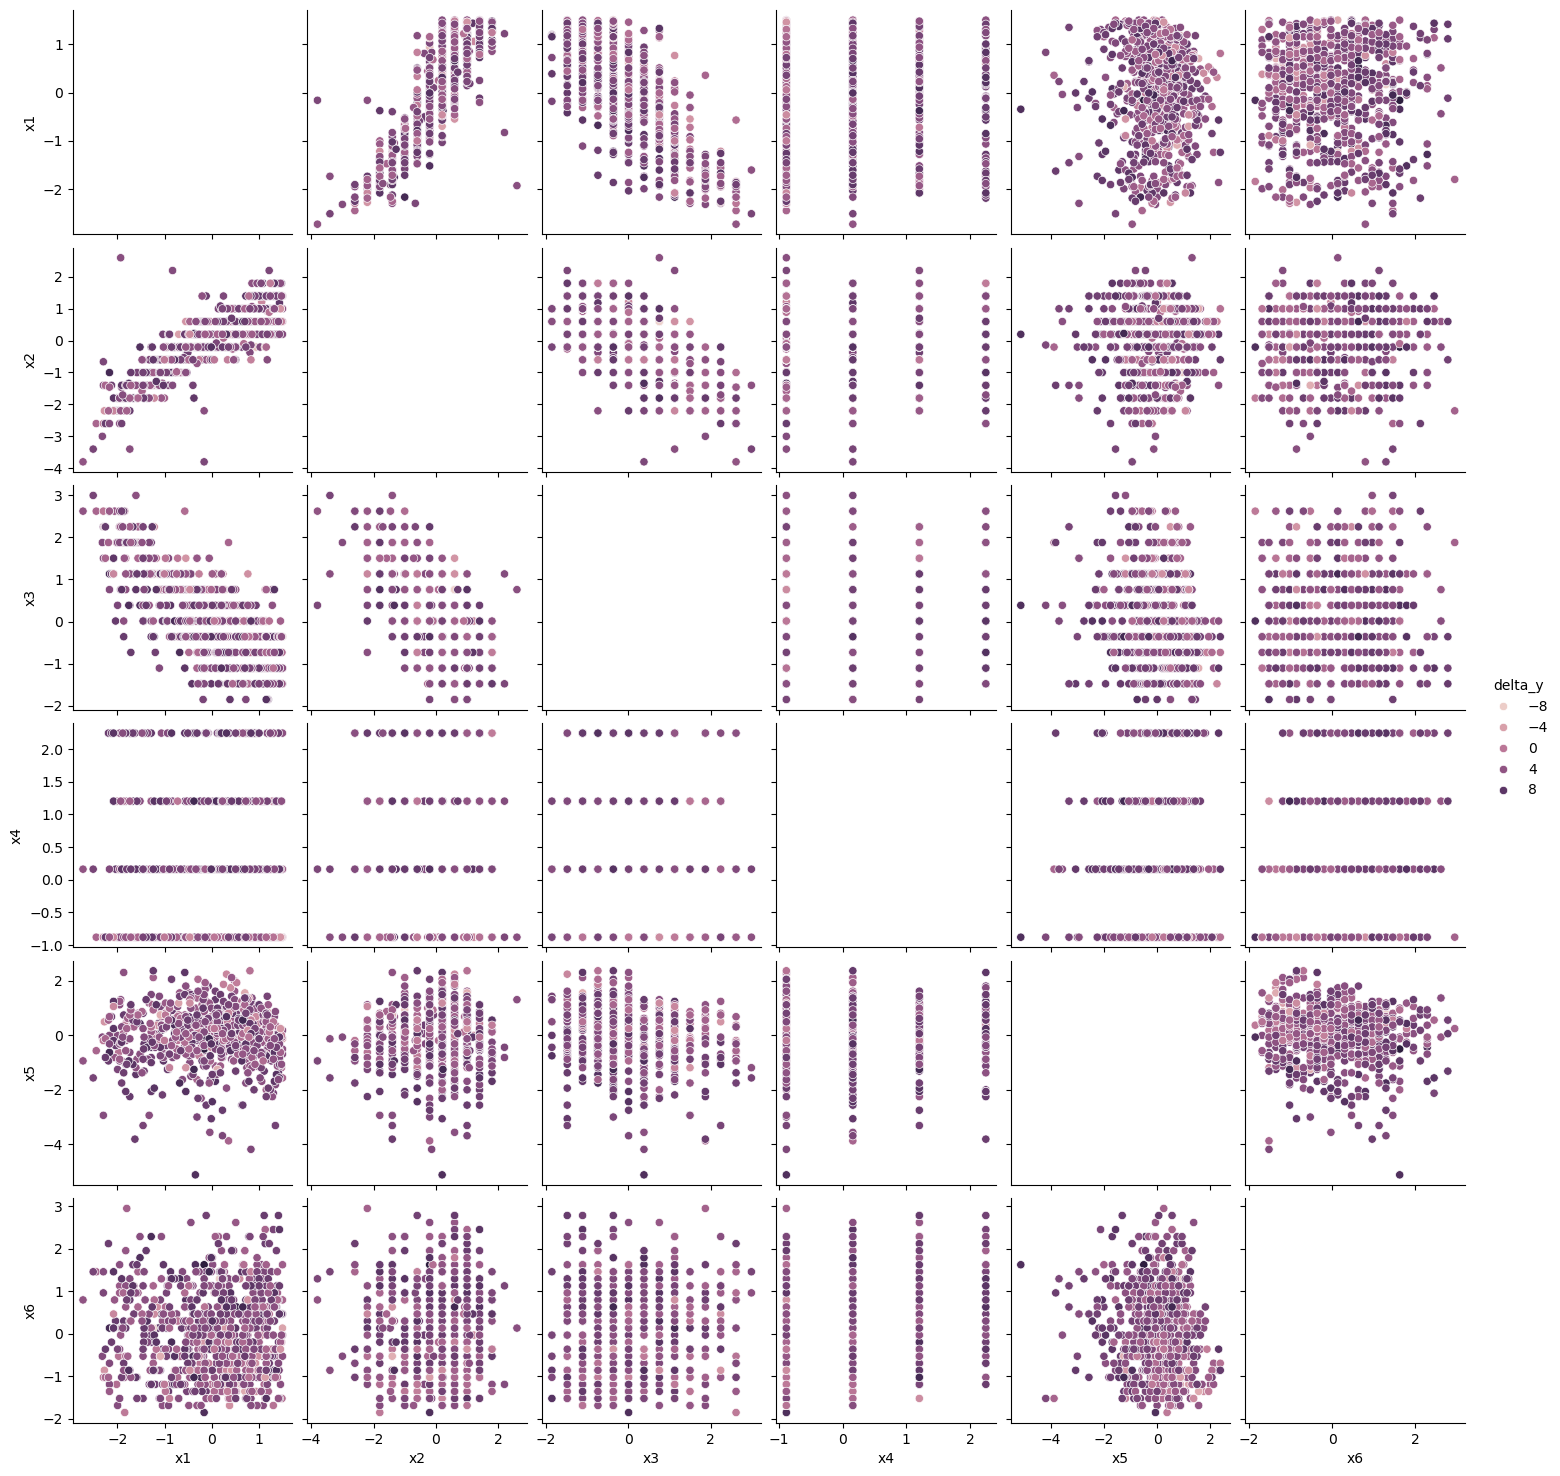

In [3]:
import seaborn as sns

x_num_y = x_numeric.copy()
x_num_y[ihdp_y_colname] = ihdp_data[ihdp_y_colname]
sns.pairplot(x_num_y, hue=ihdp_y_colname)

In [4]:
from itertools import product
from tqdm import tqdm

group_col: Final[str] = "x4"
x = x_all.drop(columns=[group_col])
x_len = len(x)
categories = x_all[group_col]
print("n_categories", len(categories.unique()))

r = np.zeros((x_len, x_len))
for i, j in tqdm(list(product(range(x_len), range(x_len)))):
    if np.isclose(categories[i], categories[j]):
        r[i, j] = 1

r

n_categories 4


100%|██████████| 558009/558009 [00:22<00:00, 24650.29it/s]


array([[1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 1.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 1.],
       [0., 0., 1., ..., 0., 1., 1.]])

# S-learner

In [5]:
from tabrel.benchmark.nw_regr import run_training, metrics_mean

labels = ["rel", "nrel", "lgb", "rel-fts", "lgb-rel"]
metrics = {
    "pehe": [[] for _ in range(len(labels))]
}

def generate_indices(seed: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    np.random.seed(seed)
    indices = np.random.permutation(x_len)
    n_query, n_back = 200, 300
    q_indices = indices[:n_query]
    b_indices = indices[n_query:n_back]
    v_indices = indices[n_back:]
    return q_indices, b_indices, v_indices


for seed in tqdm(range(10)):
    query_indices, back_indices, val_indices = generate_indices(seed)



    res = run_training(
        x=x.to_numpy(),
        y=ihdp_data[ihdp_y_colname].to_numpy(),
        r=r,
        backgnd_indices=back_indices,
        query_indices=query_indices,
        val_indices=val_indices,
        lr=1e-4,
        n_epochs=10,
        rel_as_feats=r,
    )
    for i, v in enumerate(res.values()):
        mse = v[0]
        metrics["pehe"][i].append(mse)


for i in range(len(labels)):
    metrics["pehe"][i] = np.array(metrics["pehe"][i])
metrics_mean(metrics, labels)

100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


{'pehe': [('rel', 23.533),
  ('nrel', 24.209),
  ('lgb', 3.598),
  ('rel-fts', 24.727),
  ('lgb-rel', 3.612)]}

# T-learner

In [ ]:
from tabrel.benchmark.nw_regr import train_nw_arbitrary, NwModelConfig

y_fact_colname, y_cfact_colname = "y_factual", "y_cfactual"
data_y_fact, data_treatment = ihdp_data[y_fact_colname], ihdp_data["treatment"]

def split_treated_non_treated(x: pd.DataFrame, treatment: np.ndarray, y_fact: pd.DataFrame) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    treated = treatment == 1
    x_treated, y_treated = x.loc[treated], y_fact.loc[treated]
    x_non_treated, y_non_treated = x.loc[~treated], y_fact.loc[~treated]
    return x_treated.to_numpy(), y_treated.to_numpy(), x_non_treated.to_numpy(), y_non_treated.to_numpy()

seed = 42
np.random.seed(seed)
query_indices, back_indices, val_indices = generate_indices(seed)
y_np = data_y_fact.to_numpy()
xq, xb, xv = x.iloc[query_indices], x.iloc[back_indices], x.iloc[val_indices]
yq, yb = data_y_fact.iloc[query_indices], data_y_fact.iloc[back_indices]
tq, tb = data_treatment[query_indices], data_treatment[back_indices]

xt_q, yt_q, xnt_q, ynt_q = split_treated_non_treated(xq, tq, yq)
xt_b, yt_b, xnt_b, ynt_b = split_treated_non_treated(xb, tb, yb)

iq_t = np.array([i for i in query_indices if data_treatment[i] == 1])
iq_nt = np.array([i for i in query_indices if data_treatment[i] == 0])

ib_t = np.array([i for i in back_indices if data_treatment[i] == 1])
ib_nt = np.array([i for i in back_indices if data_treatment[i] == 0])

data_y_cfact = ihdp_data[y_cfact_colname]
yv_t = np.array([data_y_fact[i] if data_treatment[i] == 1 else data_y_cfact[i] for i in val_indices])
yv_nt = np.array([data_y_fact[i] if data_treatment[i] == 0 else data_y_cfact[i] for i in val_indices])

i_train_t = np.concatenate([iq_t, ib_t])
i_train_nt = np.concatenate([iq_nt, ib_nt])

r_q_b_treated = r[iq_t][:, ib_t]
r_q_b_nt = r[iq_nt][:, ib_nt]
r_val_nvt = r[val_indices][:, i_train_t]  # rel between val and treated train
r_val_nvnt = r[val_indices][:, i_train_nt]  # rel between val and non-treated train

label_t: Final[str] = "treated"
label_nt: Final[str] = "non-treated"

trained_models = {
    "rel=True": {},
    "rel=False": {},
}
for rel, (xqi, xbi, yqi, ybi, yvi, r_q_b, r_v_nvi, label) in product(
    (True, False),
    (
        (xt_q, xt_b, yt_q, yt_b, yv_t, r_q_b_treated, r_val_nvt, label_t),
        (xnt_q, xnt_b, ynt_q, ynt_b, yv_nt, r_q_b_nt, r_val_nvnt, label_nt),
     ),
):
   _, _, _, model = train_nw_arbitrary(
       x_backgnd=xbi,
       y_backgnd=ybi,
       x_query=xqi,
       y_query=yqi,
       x_val=xv.to_numpy(),
       y_val=yvi,
       r_query_backgnd=r_q_b if rel else np.zeros_like(r_q_b),
       r_val_nonval=r_v_nvi if rel else np.zeros_like(r_v_nvi),
       cfg=NwModelConfig(),
       lr=1e-3,
       n_epochs=50,
   )
   trained_models[f"rel={rel}"][label] = model